<center>Progetto realizzato da Elena Curti (matr. 185431)

# Sentiment analysis – Amazon reviews
</center>

## Introduzione
... realizzato con MongoDB ... 


In [1]:
# !pip install happiestfuntokenizing

In [2]:
import nltk
import random
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment.util import mark_negation, extract_unigram_feats
from nltk.corpus import wordnet as wn
from pymongo import MongoClient
from happiestfuntokenizing.happiestfuntokenizing import Tokenizer


client = MongoClient('192.168.202.128', 27017)      # TODO mettere localhost
db = client.test

In [3]:
def getReviewData(database, funzione_tokenize, lista_overall, limite=1000, field="reviewText"):
    reviews = []
    for overall in lista_overall:
        for review in database.reviews.find({"overall": overall}).limit(limite):
            reviews.append((funzione_tokenize(review[field]),str(overall))) 
    random.shuffle(reviews) 
    return reviews  

def get_classifier_and_sentiment_analyzer(reviews, unigramFeats=[]):
    sentimAnalyzer = nltk.sentiment.SentimentAnalyzer()
    allWordsNeg = sentimAnalyzer.all_words([mark_negation(doc) for doc in reviews])    
    
    if unigramFeats == []:
        unigramFeats = sentimAnalyzer.unigram_word_feats(allWordsNeg, min_freq=4)   
    sentimAnalyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigramFeats)
    featureSets = sentimAnalyzer.apply_features(reviews)
    dim = int(len(reviews)/3)-1
    trainSet, testSet = featureSets[len(reviews)-dim:], featureSets[:dim]

    classifier = sentimAnalyzer.train(NaiveBayesClassifier.train, trainSet)
    return classifier, dict(sorted(sentimAnalyzer.evaluate(testSet).items()))
    # else:
    #     dev_test = [ (reviews[i][0], featureSets[i][0], featureSets[i][1]) for i in range(dim,len(reviews)-dim)]
    #     return classifier, dev_test

def print_accuracy(diz):
    print("Accuracy:", diz["Accuracy"])

    return
    for key,value in list_items:
        print('{0}: {1}'.format(key, value))

## Versione 1: World tokenizer di nltk con due classi

In [4]:
# TODO rimuovi commenti
reviews1 = getReviewData(db, nltk.word_tokenize, [1.0, 5.0])
classifier1, sent_analyzer1 = get_classifier_and_sentiment_analyzer(reviews1)
print_accuracy(sent_analyzer1)

Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.8616541353383459


## Versione 2: Sentiment tokenizer di Christopher Potts con due classi

In [5]:
reviews2 = getReviewData(db, Tokenizer().tokenize, [1.0, 5.0])
classifier2, sent_analyzer2 = get_classifier_and_sentiment_analyzer(reviews2)
print_accuracy(sent_analyzer2)

Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.8030075187969925


## Versione 3: Classificazione a cinque classi

In [6]:
# TODO rimuovi commenti
reviews3 = getReviewData(db, nltk.word_tokenize, [float(i) for i in range(1,6)],limite=100)
classifier3, sent_analyzer3 = get_classifier_and_sentiment_analyzer(reviews3)
print_accuracy(sent_analyzer3)

Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.30303030303030304


## Versione 4: Uso del field "summary"

In [7]:
reviews4 = getReviewData(db, nltk.word_tokenize, [1.0, 5.0],field="summary")
classifier4, sent_analyzer4 = get_classifier_and_sentiment_analyzer(reviews4)
print_accuracy(sent_analyzer4)

Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.7052631578947368


## Versione 5: uso dei soli aggettivi

In [8]:
reviews5 = []
for (lista_parole,classe) in reviews1:
    solo_aggettivi = []
    for par in lista_parole:
        tmp = wn.synsets(par)
        if len(tmp) > 0 and tmp[0].pos() == "a":
            solo_aggettivi.append(par)
    if solo_aggettivi != []:
        reviews5.append((solo_aggettivi,classe)) 

classifier5, sent_analyzer5 = get_classifier_and_sentiment_analyzer(reviews5)
print_accuracy(sent_analyzer5)

Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.5725190839694656


## Confronto tra le versioni
L'accuracy migliore è stata ottenuta con il sentiment tokenizer di Christopher Potts (<MARK>METTERE VALORE MEDIO</mark>). <br>
L'accuracy peggiore, invece, è stata ottenuta con la versione a cinque classi  (<MARK>METTERE VALORE MEDIO</mark>). <br>
L'accuracy della versione originale a due classi con nltk è a metà tra le due precedenti  (<MARK>METTERE VALORE MEDIO</mark>). 

In [9]:
print("Versione 1:")
classifier1.show_most_informative_features(5)

print("\nVersione 2:")
classifier2.show_most_informative_features(5)

print("\nVersione 3:")
classifier3.show_most_informative_features(5)

print("\nVersione 4:")
classifier4.show_most_informative_features(5)

print("\nVersione 5:")
classifier5.show_most_informative_features(5)

Versione 1:
Most Informative Features
         contains(waste) = True              1.0 : 5.0    =     14.3 : 1.0
            contains(64) = True              1.0 : 5.0    =     12.4 : 1.0
            contains(Do) = True              1.0 : 5.0    =     12.1 : 1.0
       contains(perfect) = True              5.0 : 1.0    =     11.4 : 1.0
       contains(awesome) = True              5.0 : 1.0    =     10.7 : 1.0

Versione 2:
Most Informative Features
         contains(money) = True              1.0 : 5.0    =     37.7 : 1.0
         contains(waste) = True              1.0 : 5.0    =     25.5 : 1.0
       contains(awesome) = True              5.0 : 1.0    =      9.1 : 1.0
         contains(worst) = True              1.0 : 5.0    =      8.5 : 1.0
          contains(fits) = True              5.0 : 1.0    =      8.3 : 1.0

Versione 3:
Most Informative Features
          contains(what) = True              3.0 : 4.0    =      7.9 : 1.0
         contains(would) = True              2.0 : 5.0    =

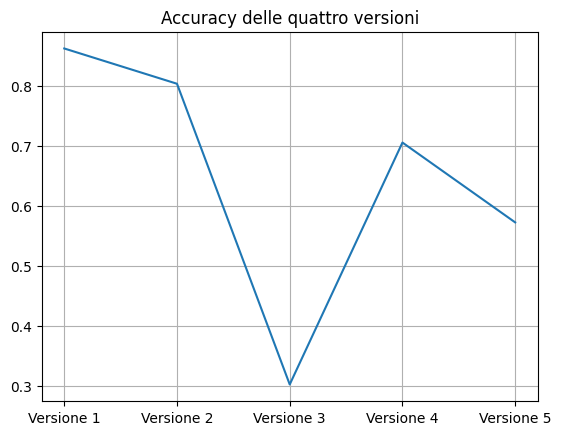

In [10]:
import matplotlib.pyplot as plt
x2 = ["Versione 1", "Versione 2", "Versione 3", "Versione 4", "Versione 5"]
y2 = [sent_analyzer1["Accuracy"],sent_analyzer2["Accuracy"],sent_analyzer3["Accuracy"], sent_analyzer4["Accuracy"], sent_analyzer5["Accuracy"]]
plt.plot(x2, y2, label = "line 2")
plt.title('Accuracy delle quattro versioni')
plt.grid()
